<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Trends Prediction in Thailand Using Time Series Neural Networks

---


We used convolutional neural network (CNN), recurrent neural networks (RNNs), gated recurrent unit (GRU) and long short-term memory (LSTM) to predict Covid-19 cases and deaths in Thailand, using 14 previous days as samples to predict the next 1 day. These models particularly deal with time series data. Further, we ran multivariate neural networks with policy implementations, mobility changes, transportation behavior changes, vaccination, confirmed cases (for predicting deaths) and confirmed deaths (for predicting cases) as additional predictors. Our goal was to minimize the mean average percentage error (MAPE) between the actual values and predictions.  



## Data Sources


The Covid-19 data was from https://github.com/CSSEGISandData/COVID-19 by John Hopkins University. The data included both confirmed infects and confirmed deaths reported by Thailand’s Ministry of Public Health. 
Policy implementation in Thailand data was gathered by Oxford Covid-19 Government Response Tracker (OxCGRT) (https://github.com/OxCGRT/covid-policy-tracker). This policy record indicated when and how the government in each country responded to the pandemic at specific time periods. We used containment and health index which consisted of school closing, workplace closing, canceling public events, restrictions on gatherings, close public transport, stay at home requirements, international travel controls, and public information campaign. Each indicator was coded in different levels of implementations (see more: ​​https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md)
The mobility data was from Google (https://www.google.com/covid19/mobility). Google calculated the changes of mobility based on Location History of users on Google Map. The baseline of the changes was the median value from January, 3rd to February 6th, 2020. There were four categories: groceries and pharmacy, retail and recreation, transit stations, and finally, parks. Another source of mobility was from Apple where it tracked driving and walking behaviors during the pandemic (https://covid19.apple.com/mobility). 
Vaccination count was gathered from Thailand’s Ministry of Health (https://github.com/porames/the-researcher-covid-data?fbclid=IwAR1-SAiA8pMKD5qbcN7S5c-p_snBIIWd42wYOq4qiM9yA6FTf_GcyYgxtvA). This vaccination information that was used in this study was the amount of Thai people who received their first shot, second shot of vaccines, regardless of the vaccine types. 
Finally, the last input data was transportation behavior from Thai’s Ministry of Transportation (https://datagov.mot.go.th/dataset/covid-19/resource/71a552d0-0fea-4e05-b78c-42d58aa88db6?fbclid=IwAR18p4TQY3qlD9snnhADdvrAWVjOgofse54GbNKm8Qb-pMgBb-ZejebWD-w). The information included the rate of use for both public and private transportation systems in Thailand. 



## Import packages

In [1]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Import data

In [7]:
data = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/data.csv")

data_i = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/data_i.csv")

data_d = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/data_d.csv")

actual = read_csv("https://github.com/Tanainan/Covid-19Thailand/raw/main/actual.csv") # this is for comparison with future prediction (final part)

# use the previous 14 days to predict the next day
lag = 14
prediction = 1

## Methods

---


The data was available from February 22nd, 2020 to September 9th, 2021 (as the date the data was retrieved). However, the third wave of the epidemic in Thailand started after April 1st, 2021, and the trend started to rise after June. Thus, we used the data from, June 15th to July 29th, 2021 for our training; July 30th to August 18th, 2021 for our validation, and August 19th to September 2nd, 2021 for our prediction. There were 31 samples in total for training, 20 samples for validation, and predictions of 15 days ahead. 

Since confirmed cases and confirmed deaths (and vaccination) data were given in cumulative counts, we computed the daily cases and deaths (and vaccination) to match the format of other predictors: mobility and transportation changes. The continuous variables were scaled and centered. Neural networks required input and output in forms of matrices. The experiments consisted of univariate and multivariate approaches for training, validation, and prediction

For the univariate, we created an input matrix with 14 columns as the previous 14 days input. The number of rows was equal to total samples - 14 days - 1-day prediction + 1 or 31 rows. To demonstrate, the first row would have the 1st to the 14th day. The second row would have the 2nd to the 15th day, and so forth as a rolling window. The output matrix would be the 1 column for 1-day prediction with the same amount of rows as the input matrix. For example, the first row would be the 15th day for the 1-day prediction. Since the neural networks could only work with at least 2 dimensions, we transformed both input and output matrices into 3 dimensions (with 1 as the third dimension).

## Data Preprocessing: Univariate

In [3]:
def split_sequence(sequence, lag):
	x, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + lag
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		x.append(seq_x)
		y.append(seq_y)
	return array(x), array(y)


In [4]:
# confirmed cases
x_i, y_i = split_sequence(data.infected, lag)

# split into training and test sets
index = 30 # 31 days for training and 7 days for test
X_i_tr = x_i[0:index+1, :]
X_i_ts = x_i[index+1:x_i.shape[0], :]
X_i_tr = X_i_tr.reshape(31,14,1) # reshape input into 3D
X_i_ts = X_i_ts.reshape(20,14,1)

y_i_tr = y_i[0:index+1]
y_i_ts = y_i[index+1:x_i.shape[0]]
y_i_tr = y_i_tr.reshape(31,1,1) # reshape output into 3D
y_i_ts = y_i_ts.reshape(20,1,1)       

# confirmed deaths
x_d, y_d = split_sequence(data.death, lag)

# split
X_d_tr = x_d[0:index+1, :]
X_d_ts = x_d[index+1:x_d.shape[0], :]
X_d_tr = X_d_tr.reshape(31,14,1)
X_d_ts = X_d_ts.reshape(20,14,1)

y_d_tr = y_d[0:index+1]
y_d_ts = y_d[index+1:x_d.shape[0]]
y_d_tr = y_d_tr.reshape(31,1,1)
y_d_ts = y_d_ts.reshape(20,1,1)

For the multivariate prediction, the input matrix included 14 columns and 31 rows (total samples - 14 days - 14-days prediction + 1). The output matrices’ columns were the same as in the univariate prediction. However, since we had many predictors, we created tensors for each predictor. Note that all categorical predictors must be transformed by one-hot coding beforehand. Thus, the input matrix for the multivariate would have 3 dimensions. A few cells of missing data from Apple mobility were replaced with an average of its data.

## Data Preprocessing: Multivariate

In [5]:
# confirmed cases
nrow_total = data_i.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data_i[i:lag+i], axis=0) for i in range(nrow_total)] 
X_i_p = np.concatenate(input_list, axis=0)

y_i_p = np.array([data_i.data_i[lag:data_i.shape[0]]])
y_i_p = y_i_p.T # transpose the matrix

# split into training and test sets
index = 30 # 31 days for training and 7 days for test
X_i_p_tr = X_i_p[0:index+1, :, :]
X_i_p_ts = X_i_p[index+1:data_i.shape[0], :, :]

y_i_p_tr = y_i_p[0:index+1]
y_i_p_ts = y_i_p[index+1:data_i.shape[0]]


In [6]:
# confirmed deaths
nrow_total = data_d.shape[0] - lag - prediction + 1
input_list = [np.expand_dims(data_d[i:lag+i], axis=0) for i in range(nrow_total)] 
X_d_p = np.concatenate(input_list, axis=0)

y_d_p = np.array([data_d.data_d[lag:data_d.shape[0]]])
y_d_p = y_d_p.T # transpose the matrix


# split into training and test sets
index = 30
X_d_p_tr = X_d_p[0:index+1, :, :]
X_d_p_ts = X_d_p[index+1:data_d.shape[0], :, :]

y_d_p_tr = y_d_p[0:index+1]
y_d_p_ts = y_d_p[index+1:data_d.shape[0]]

## Analysis

---



### Hyperparameters Tuning


Using the training set matrices from confirmed cases and confirmed deaths and univiariate and multivariate, we tuned for the most optimal numbers of parameters. In this case, we searched for numbers of nodes for LSTM, GRU, and RNNs, and filter, kernel size, and pool for CNN. The numbers of nodes that we used for our LSTM, GRU, and RNNs experiments were 4, 8, 16, 32, 64, 128, 256, and 512. Similarly, we used the same pool for CNN filter with kernel size of 5 and 7, and pool of 2 and 3. Each model (i.e., CNN, GRU, LSTM, and RNNs) would consist of one hidden layer with an activation function of Rectified Linear Unit (ReLu) and an output layer with one node and Linear activation function. Epoch and batch size were 30 and 1, respectively. We used mean squared error (MSE) as our loss function and mean absolute percentage error (MAPE) as a metric for model evaluation.


### CNN

In [ ]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 30, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [4, 8, 16, 32, 64, 128, 256, 512] 


In [ ]:
# Univariate CNN confirmed cases
kernel = [5, 7]
pool = [2]

cnn_i_uni = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr, y_i_tr)
    cnn_i_uni.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_tr, y_i_tr)
    cnn_i_uni.append(score)

cnn_i_uni = pd.DataFrame(cnn_i_uni).T
cnn_i_uni.columns = ['k5p2', 'k7p2', 'k5p3', 'k7p3'] # k5p2: kernel size = 5, pool = 2

filter = 4, kernel size = 5, pooling size = 2: 93.609
filter = 8, kernel size = 5, pooling size = 2: 66.779
filter = 16, kernel size = 5, pooling size = 2: 28.337
filter = 32, kernel size = 5, pooling size = 2: 26.823
filter = 64, kernel size = 5, pooling size = 2: 23.548
filter = 128, kernel size = 5, pooling size = 2: 26.142
filter = 256, kernel size = 5, pooling size = 2: 26.539
filter = 512, kernel size = 5, pooling size = 2: 35.898
filter = 4, kernel size = 7, pooling size = 2: 51.977
filter = 8, kernel size = 7, pooling size = 2: 36.383
filter = 16, kernel size = 7, pooling size = 2: 43.968
filter = 32, kernel size = 7, pooling size = 2: 29.676
filter = 64, kernel size = 7, pooling size = 2: 23.162
filter = 128, kernel size = 7, pooling size = 2: 29.440
filter = 256, kernel size = 7, pooling size = 2: 35.442
filter = 512, kernel size = 7, pooling size = 2: 39.372
filter = 4, kernel size = 5, pooling size = 3: 70.447
filter = 8, kernel size = 5, pooling size = 3: 43.076
filter = 1

In [ ]:
# Univariate CNN confirmed deaths
pool = [2]

cnn_d_uni = list()

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = list()
    score = run_experiment(filter, kernel_size, pool, X_d_tr, y_d_tr)
    cnn_d_uni.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = list()
    score = run_experiment(filter, kernel_size, pool, X_d_tr, y_d_tr)
    cnn_d_uni.append(score)

cnn_d_uni = pd.DataFrame(cnn_d_uni).T
cnn_d_uni.columns = ['k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 4, kernel size = 5, pooling size = 2: 61.240
filter = 8, kernel size = 5, pooling size = 2: 65.869
filter = 16, kernel size = 5, pooling size = 2: 43.981
filter = 32, kernel size = 5, pooling size = 2: 43.937
filter = 64, kernel size = 5, pooling size = 2: 41.108
filter = 128, kernel size = 5, pooling size = 2: 34.930
filter = 256, kernel size = 5, pooling size = 2: 29.529
filter = 512, kernel size = 5, pooling size = 2: 103.519
filter = 4, kernel size = 7, pooling size = 2: 63.467
filter = 8, kernel size = 7, pooling size = 2: 60.035
filter = 16, kernel size = 7, pooling size = 2: 39.691
filter = 32, kernel size = 7, pooling size = 2: 43.630
filter = 64, kernel size = 7, pooling size = 2: 35.875
filter = 128, kernel size = 7, pooling size = 2: 33.693
filter = 256, kernel size = 7, pooling size = 2: 27.609
filter = 512, kernel size = 7, pooling size = 2: 27.643
filter = 4, kernel size = 5, pooling size = 3: 74.676
filter = 8, kernel size = 5, pooling size = 3: 61.734
filter = 

In [ ]:
# Multivariate CNN confirmed cases

pool = [2]
cnn_i_multi = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_i_p_tr, y_i_p_tr)
    cnn_i_multi.append(score)

cnn_i_multi = pd.DataFrame(cnn_i_multi).T
cnn_i_multi.columns = ['k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 4, kernel size = 5, pooling size = 2: 39.993
filter = 8, kernel size = 5, pooling size = 2: 19.510
filter = 16, kernel size = 5, pooling size = 2: 43.586
filter = 32, kernel size = 5, pooling size = 2: 22.329
filter = 64, kernel size = 5, pooling size = 2: 11.689
filter = 128, kernel size = 5, pooling size = 2: 4.550
filter = 256, kernel size = 5, pooling size = 2: 7.623
filter = 512, kernel size = 5, pooling size = 2: 17.143
filter = 4, kernel size = 7, pooling size = 2: 45.506
filter = 8, kernel size = 7, pooling size = 2: 20.347
filter = 16, kernel size = 7, pooling size = 2: 53.595
filter = 32, kernel size = 7, pooling size = 2: 29.062
filter = 64, kernel size = 7, pooling size = 2: 29.361
filter = 128, kernel size = 7, pooling size = 2: 6.886
filter = 256, kernel size = 7, pooling size = 2: 12.660
filter = 512, kernel size = 7, pooling size = 2: 12.587
filter = 4, kernel size = 5, pooling size = 3: 74.753
filter = 8, kernel size = 5, pooling size = 3: 38.874
filter = 16, 

In [ ]:
# Multivariate CNN confirmed deaths

pool = [2]
cnn_d_multi = list()

for i in kernel:
  for j in pool:
    score = list() 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_d_p_tr, y_d_p_tr)
    cnn_d_multi.append(score)

cnn_d_multi = pd.DataFrame(cnn_d_multi).T
cnn_d_multi.columns = ['k5p2', 'k7p2', 'k5p3', 'k7p3']

filter = 4, kernel size = 5, pooling size = 2: 41.721
filter = 8, kernel size = 5, pooling size = 2: 46.334
filter = 16, kernel size = 5, pooling size = 2: 39.373
filter = 32, kernel size = 5, pooling size = 2: 75.988
filter = 64, kernel size = 5, pooling size = 2: 31.074
filter = 128, kernel size = 5, pooling size = 2: 45.129
filter = 256, kernel size = 5, pooling size = 2: 28.773
filter = 512, kernel size = 5, pooling size = 2: 36.224
filter = 4, kernel size = 7, pooling size = 2: 53.195
filter = 8, kernel size = 7, pooling size = 2: 57.822
filter = 16, kernel size = 7, pooling size = 2: 52.121
filter = 32, kernel size = 7, pooling size = 2: 38.501
filter = 64, kernel size = 7, pooling size = 2: 89.061
filter = 128, kernel size = 7, pooling size = 2: 39.546
filter = 256, kernel size = 7, pooling size = 2: 37.333
filter = 512, kernel size = 7, pooling size = 2: 36.422
filter = 4, kernel size = 5, pooling size = 3: 52.642
filter = 8, kernel size = 5, pooling size = 3: 55.126
filter = 1

### LSTM

In [ ]:
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 30, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

In [ ]:
# Univariate LSTM confirmed cases
units = [4,8,16,32,64,128,256,512]

lstm_i_uni = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_tr, y_i_tr, i)
  lstm_i_uni.append(score)

In [ ]:
# Univariate LSTM confirmed deaths

lstm_d_uni = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_tr, y_d_tr, i)
  lstm_d_uni.append(score)

In [ ]:
# Multivariate LSTM confirmed cases

lstm_i_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_i_p_tr, y_i_p_tr, i)
  lstm_i_multi.append(score)

In [ ]:
# Multivariate LSTM confirmed deaths

lstm_d_multi = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_d_p_tr, y_d_p_tr, i)
  lstm_d_multi.append(score)

### GRU

In [ ]:
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 30, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

In [ ]:
# Univariate GRU confirmed cases

gru_i_uni = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_tr, y_i_tr, i)
  gru_i_uni.append(score)

In [ ]:
# Univariate GRU confirmed deaths

gru_d_uni = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_tr, y_d_tr, i)
  gru_d_uni.append(score)

In [ ]:
# Multivariate GRU confirmed cases

gru_i_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_i_p_tr, y_i_p_tr, i)
  gru_i_multi.append(score)

In [ ]:
# Multivariate GRU confirmed deaths

gru_d_multi = list()

for i in units:
  score = list()
  score = evaluate_gru(X_d_p_tr, y_d_p_tr, i)
  gru_d_multi.append(score)

### RNNs

In [ ]:
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 30, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

In [ ]:
# Univariate RNNs confirmed cases

rnn_i_uni = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_tr, y_i_tr, i)
  rnn_i_uni.append(score)

In [ ]:
# Univariate RNNs confirmed deaths

rnn_d_uni = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_tr, y_d_tr, i)
  rnn_d_uni.append(score)

In [ ]:
# Multivariate RNNs confirmed cases

rnn_i_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_i_p_tr, y_i_p_tr, i)
  rnn_i_multi.append(score)

In [ ]:
# Multivariate RNNs confirmed deaths

rnn_d_multi = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_d_p_tr, y_d_p_tr, i)
  rnn_d_multi.append(score)

### Plots

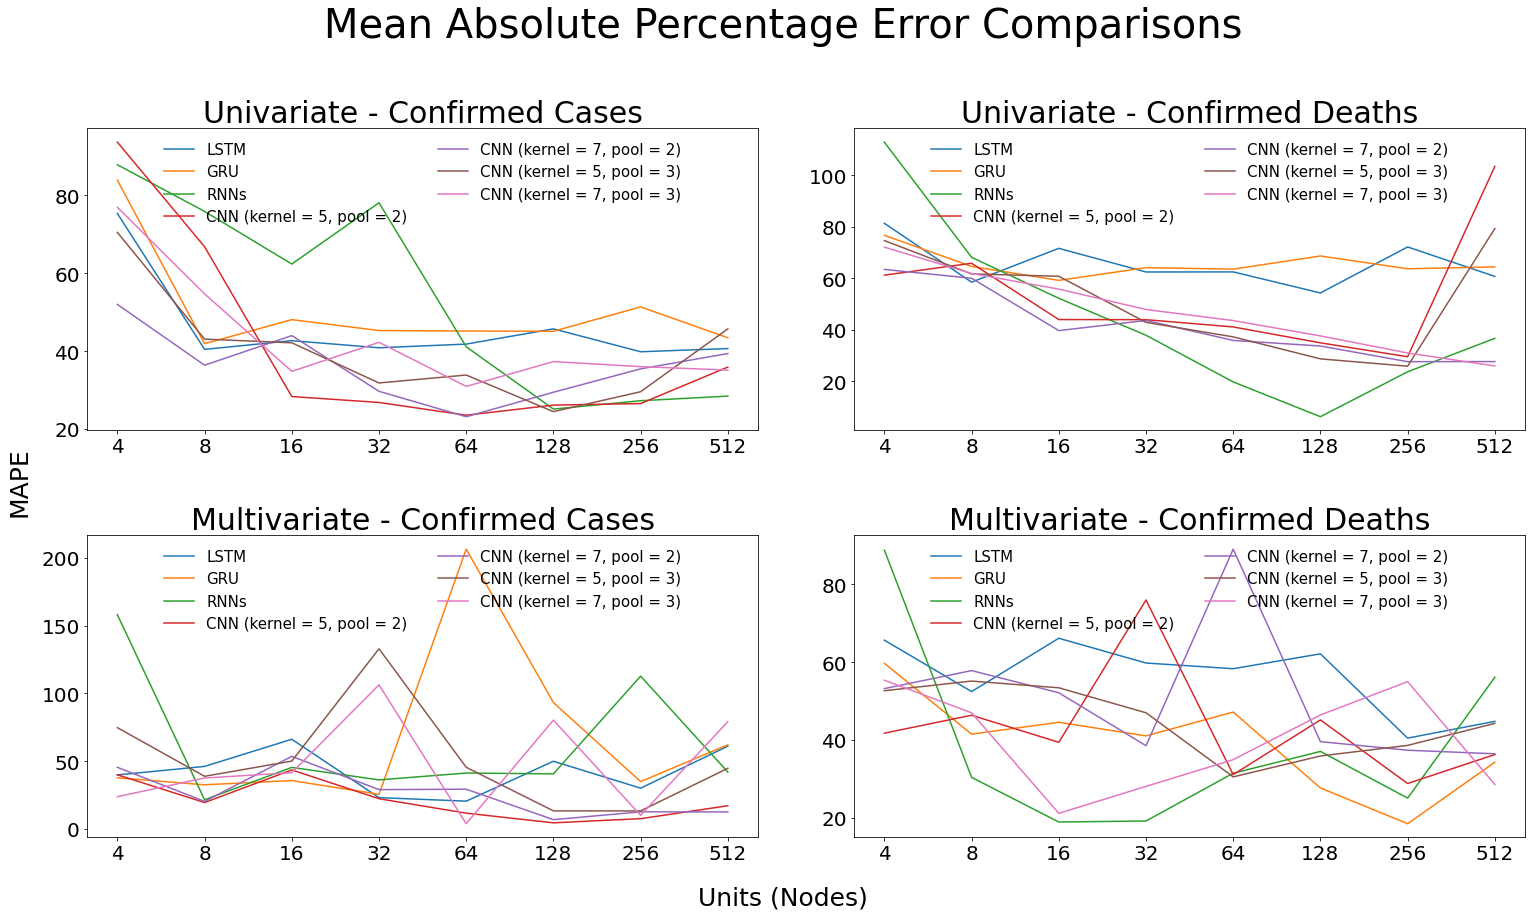

In [ ]:
units = ['4', '8', '16', '32', '64', '128','256','512'] # change to string

fig, axes = plt.subplots(2, 2, figsize=(22,12))
fig.suptitle("Mean Absolute Percentage Error Comparisons", fontsize=40, y=1.05)

axes[0,0].plot(units, lstm_i_uni, label = "LSTM")
axes[0,0].plot(units, gru_i_uni, label = "GRU")
axes[0,0].plot(units, rnn_i_uni, label = "RNNs")
axes[0,0].plot(units, cnn_i_uni['k5p2'], label = "CNN (kernel = 5, pool = 2)")
axes[0,0].plot(units, cnn_i_uni['k7p2'], label = "CNN (kernel = 7, pool = 2)")
axes[0,0].plot(units, cnn_i_uni['k5p3'], label = "CNN (kernel = 5, pool = 3)")
axes[0,0].plot(units, cnn_i_uni['k7p3'], label = "CNN (kernel = 7, pool = 3)")
axes[0,0].set_xticks(units)
axes[0,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 15)
axes[0,0].set_title("Univariate - Confirmed Cases", fontsize = 30)
axes[0,0].tick_params(axis='both', which='major', labelsize=20)


axes[0,1].plot(units, lstm_d_uni, label = "LSTM")
axes[0,1].plot(units, gru_d_uni, label = "GRU")
axes[0,1].plot(units, rnn_d_uni, label = "RNNs")
axes[0,1].plot(units, cnn_d_uni['k5p2'], label = "CNN (kernel = 5, pool = 2)")
axes[0,1].plot(units, cnn_d_uni['k7p2'], label = "CNN (kernel = 7, pool = 2)")
axes[0,1].plot(units, cnn_d_uni['k5p3'], label = "CNN (kernel = 5, pool = 3)")
axes[0,1].plot(units, cnn_d_uni['k7p3'], label = "CNN (kernel = 7, pool = 3)")
axes[0,1].set_xticks(units)
axes[0,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 15)
axes[0,1].set_title("Univariate - Confirmed Deaths", fontsize = 30)
axes[0,1].tick_params(axis='both', which='major', labelsize=20)


axes[1,0].plot(units, lstm_i_multi, label = "LSTM")
axes[1,0].plot(units, gru_i_multi, label = "GRU")
axes[1,0].plot(units, rnn_i_multi, label = "RNNs")
axes[1,0].plot(units, cnn_i_multi['k5p2'], label = "CNN (kernel = 5, pool = 2)")
axes[1,0].plot(units, cnn_i_multi['k7p2'], label = "CNN (kernel = 7, pool = 2)")
axes[1,0].plot(units, cnn_i_multi['k5p3'], label = "CNN (kernel = 5, pool = 3)")
axes[1,0].plot(units, cnn_i_multi['k7p3'], label = "CNN (kernel = 7, pool = 3)")
axes[1,0].set_xticks(units)
axes[1,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 15)
axes[1,0].set_title("Multivariate - Confirmed Cases", fontsize = 30)
axes[1,0].tick_params(axis='both', which='major', labelsize=20)


axes[1,1].plot(units, lstm_d_multi, label = "LSTM")
axes[1,1].plot(units, gru_d_multi, label = "GRU")
axes[1,1].plot(units, rnn_d_multi, label = "RNNs")
axes[1,1].plot(units, cnn_d_multi['k5p2'], label = "CNN (kernel = 5, pool = 2)")
axes[1,1].plot(units, cnn_d_multi['k7p2'], label = "CNN (kernel = 7, pool = 2)")
axes[1,1].plot(units, cnn_d_multi['k5p3'], label = "CNN (kernel = 5, pool = 3)")
axes[1,1].plot(units, cnn_d_multi['k7p3'], label = "CNN (kernel = 7, pool = 3)")
axes[1,1].set_xticks(units)
axes[1,1].tick_params(axis='both', which='major', labelsize=20)
axes[1,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 15)
axes[1,1].set_title("Multivariate - Confirmed Deaths", fontsize = 30)

fig.text(0.5, 0.01, 'Units (Nodes)', ha='center', fontsize=25)
fig.text(0.01, 0.5, 'MAPE', va='center', rotation='vertical', fontsize=25)
fig.tight_layout(pad = 5)
plt.show()

Figures above show the tuning results. The lowest values of MAPE would indicate the most optimal model for our training data. According to the results, the best models from parameter tuning were CNN with filter = 64, kernel size = 7, and pool = 2 for univariate confirmed cases; RNNs with 128 nodes confirmed deaths; CNN with filter = 64, kernel size = 7, pool = 3 for multivariate confirmed cases, and finally, RNNs with 32 nodes for multivariate confirmed deaths. 

## Training and Validation

### Univariate CNN: Confirmed Cases

In [120]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

model_cnn_i = Sequential()
model_cnn_i.add(Conv1D(filters = 64, kernel_size=7, activation="relu", input_shape=(X_i_tr.shape[1], 1)))
model_cnn_i.add(MaxPooling1D(pool_size = 2))
model_cnn_i.add(Flatten())
model_cnn_i.add(Dense(8, activation = "relu"))
model_cnn_i.add(Dense(1, activation = "linear"))
model_cnn_i.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_cnn_i.fit(X_i_tr, y_i_tr, 
                           epochs=30, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

In [121]:
scores_cnn_i1 = model_cnn_i.evaluate(X_i_tr, y_i_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_cnn_i1[1])

scores_cnn_i = model_cnn_i.evaluate(X_i_ts, y_i_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_cnn_i[1])

MAPE: training =  21.28533172607422
MAPE: test =  38.21299362182617


In [122]:
# make a prediction
# training set
y_cnn_i_tr = pd.DataFrame(model_cnn_i.predict(X_i_tr))

# test set
y_cnn_i_ts = pd.DataFrame(model_cnn_i.predict(X_i_ts))

# combine training and test predictions
y_cnn_i_total0 = pd.concat([y_cnn_i_tr, y_cnn_i_ts], ignore_index=True)

# convert the prediction back to original values
y_cnn_i_total = y_cnn_i_total0*stdev(data.Cases_daily) + mean(data.Cases_daily)

### Univariate RNNs: Confirmed Deaths

In [95]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

model_rnn_d = Sequential()
model_rnn_d.add(SimpleRNN(128, activation="relu", input_shape=(X_d_tr.shape[1], 1)))
model_rnn_d.add(Dense(1, activation = "linear"))
model_rnn_d.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_rnn_d.fit(X_d_tr, y_d_tr, 
                           epochs=30, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

In [96]:
scores_rnn_d1 = model_rnn_d.evaluate(X_d_tr, y_d_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_rnn_d1[1])

scores_rnn_d = model_rnn_d.evaluate(X_d_ts, y_d_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_rnn_d[1])

MAPE: training =  6.2080535888671875
MAPE: test =  63.729026794433594


In [97]:
# make a prediction
# training set
y_rnn_d_tr = pd.DataFrame(model_rnn_d.predict(X_d_tr))

# test set
y_rnn_d_ts = pd.DataFrame(model_rnn_d.predict(X_d_ts))

# combine training and test predictions
y_rnn_d_total0 = pd.concat([y_rnn_d_tr, y_rnn_d_ts], ignore_index=True)

# convert the prediction back to original values
y_rnn_d_total = y_rnn_d_total0*stdev(data.Deaths_daily) + mean(data.Deaths_daily)

### Multivariate CNN: Confirmed Cases

In [76]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

model_cnn_i_p = Sequential()
model_cnn_i_p.add(Conv1D(filters = 64, kernel_size=7, activation="relu", input_shape=(X_i_p_tr.shape[1], X_i_p_tr.shape[2])))
model_cnn_i_p.add(MaxPooling1D(pool_size = 3))
model_cnn_i_p.add(Flatten())
model_cnn_i_p.add(Dense(1, activation = "linear"))
model_cnn_i_p.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_cnn_i_p.fit(X_i_p_tr, y_i_p_tr, 
                           epochs=30, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

In [77]:
scores_cnn_i_p1 = model_cnn_i_p.evaluate(X_i_p_tr, y_i_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_cnn_i_p1[1])

scores_cnn_i_p = model_cnn_i_p.evaluate(X_i_p_ts, y_i_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_cnn_i_p[1])

MAPE: training =  3.8942370414733887
MAPE: test =  22.41012954711914


In [78]:
# make a prediction
# training set
y_cnn_i_p_tr = pd.DataFrame(model_cnn_i_p.predict(X_i_p_tr))

# test set
y_cnn_i_p_ts = pd.DataFrame(model_cnn_i_p.predict(X_i_p_ts))

# combine training and test predictions
y_cnn_i_p_total0 = pd.concat([y_cnn_i_p_tr, y_cnn_i_p_ts], ignore_index=True)

# convert the prediction back to original values
y_cnn_i_p_total = y_cnn_i_p_total0*stdev(data.Cases_daily) + mean(data.Cases_daily)

### Multivariate RNNs: Confirmed Deaths

In [62]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

model_rnn_d_p = Sequential()
model_rnn_d_p.add(SimpleRNN(32, activation="relu", input_shape=(X_d_p_tr.shape[1], X_d_p_tr.shape[2]),return_sequences= True))
model_rnn_d_p.add(Dense(16, activation = "relu"))
model_rnn_d_p.add(SimpleRNN(8, activation="relu"))
model_rnn_d_p.add(Dense(1, activation = "linear"))
model_rnn_d_p.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_rnn_d_p.fit(X_d_p_tr, y_d_p_tr, 
                           epochs=30, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

In [63]:
scores_rnn_d_p1 = model_rnn_d_p.evaluate(X_d_p_tr, y_d_p_tr, verbose=0)

# MAPE
print("MAPE: training = ",scores_rnn_d_p1[1])

scores_rnn_d_p = model_rnn_d_p.evaluate(X_d_p_ts, y_d_p_ts, verbose=0)

# MAPE
print("MAPE: test = ",scores_rnn_d_p[1])

MAPE: training =  14.478779792785645
MAPE: test =  57.29045486450195


In [55]:
# make a prediction
# training set
y_rnn_d_p_tr = pd.DataFrame(model_rnn_d_p.predict(X_d_p_tr))

# test set
y_rnn_d_p_ts = pd.DataFrame(model_rnn_d_p.predict(X_d_p_ts))

# combine training and test predictions
y_rnn_d_p_total0 = pd.concat([y_rnn_d_p_tr, y_rnn_d_p_ts], ignore_index=True)

# convert the prediction back to original values
y_rnn_d_p_total = y_rnn_d_p_total0*stdev(data.Deaths_daily) + mean(data.Deaths_daily)

### Plots

In [123]:
infect = pd.concat([y_cnn_i_total, 
                   y_cnn_i_p_total, 
                   data.Cases_daily.iloc[14:].reset_index(drop = True), 
                   data.Date.iloc[14:].reset_index(drop = True)],
                   axis=1)
infect.columns = ['cnn', 'Mcnn', 'actual', 'Date']

death = pd.concat([y_rnn_d_total, 
                   y_rnn_d_p_total, 
                   data.Deaths_daily.iloc[14:].reset_index(drop = True), 
                   data.Date.iloc[14:].reset_index(drop = True)],
                  axis=1)
death.columns = ['rnn', 'Mrnn','actual', 'Date']
tick_spacing = 5

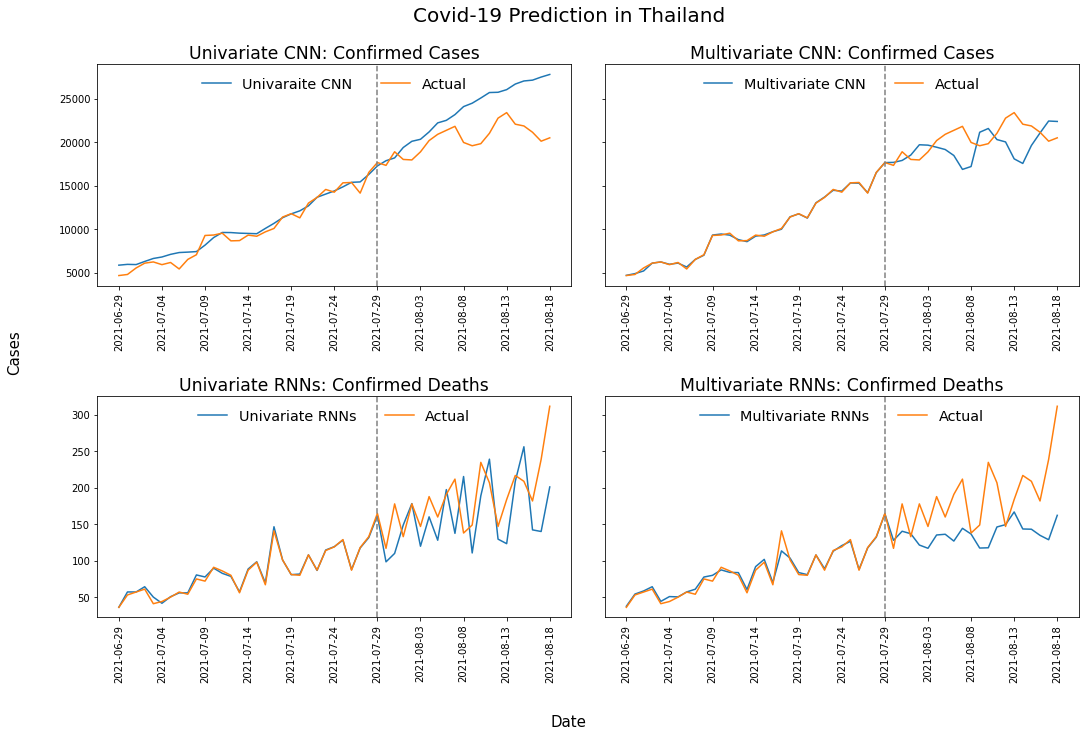

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), sharey='row') 
fig.suptitle("Covid-19 Prediction in Thailand", fontsize=20)

# Univariate confirmed cases
axes[0, 0].plot(infect['Date'],infect['cnn'], label = "Univaraite CNN")
axes[0, 0].plot(infect['Date'],infect['actual'], label = "Actual")
axes[0, 0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0, 0].set_title("Univariate CNN: Confirmed Cases", fontsize = 'xx-large')
axes[0, 0].tick_params('x',labelrotation=90)
axes[0, 0].axvline("2021-07-29", color="gray", linestyle="--")
axes[0, 0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# Multivariate confirmed cases
axes[0, 1].plot(infect['Date'],infect['Mcnn'], label = "Multivariate CNN")
axes[0, 1].plot(infect['Date'],infect['actual'], label = "Actual")
axes[0, 1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0, 1].set_title("Multivariate CNN: Confirmed Cases", fontsize = 'xx-large')
axes[0, 1].tick_params('x',labelrotation=90)
axes[0, 1].axvline("2021-07-29", color="gray", linestyle="--")
axes[0, 1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# Univariate confirmed deaths
axes[1, 0].plot(death['Date'],death['rnn'], label = "Univariate RNNs")
axes[1, 0].plot(death['Date'],death['actual'], label = "Actual")
axes[1, 0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1, 0].set_title("Univariate RNNs: Confirmed Deaths", fontsize = 'xx-large')
axes[1, 0].tick_params('x',labelrotation=90)
axes[1, 0].axvline("2021-07-29", color="gray", linestyle="--")
axes[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


# Multivariate confirmed deaths
axes[1, 1].plot(death['Date'],death['Mrnn'], label = "Multivariate RNNs")
axes[1, 1].plot(death['Date'],death['actual'], label = "Actual")
axes[1, 1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1, 1].set_title("Multivariate RNNs: Confirmed Deaths", fontsize = 'xx-large')
axes[1, 1].tick_params('x',labelrotation=90)
axes[1, 1].axvline("2021-07-29", color="gray", linestyle="--")
axes[1, 1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))


fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()

Figures above represent disparity between predicted and actual confirmed cases and confirmed deaths. In each plot, the models were trained on the left hand side and validated on the right hand side. Fourteen days (June 15th to June 28th, 2021) were omitted from the graphs since they were used as an input.

### Result Table

In [125]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model Type', 'Best Model', 'Training', 'Test'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Univariate: Confirmed Cases', 
                                                   'Univariate: Confirmed Deaths',
                                                   'Multivariate: Confirmed Cases',
                                                   'Multivariate: Confirmed Deaths'],
                                                  ['CNN', 'RNNs', 'CNN', 'RNNs'],
                                    [round(scores_cnn_i1[1],3), round(scores_rnn_d1[1],3),
                                     round(scores_cnn_i_p1[1],3), round(scores_rnn_d_p1[1],3)],
                                    [round(scores_cnn_i[1],3), round(scores_rnn_d[1],3),
                                     round(scores_cnn_i_p[1],3), round(scores_rnn_d_p[1],3)]],
                            align=['left','center', 'center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error",title_x=0.5)
fig.show()

Although, our best models seemed to performed well in training, they failed when using a test set. The validation MAPE scores were very high and there was a great disparity between the predicted and actual values in each plot. 

## Future Predictions

---

Covid-19 confirmed cases and confirmed deaths of the next 15 days from August 19th to September 2nd, 2021 were predicted based on 14 previous days. Since the prediction period was longer than 14 days, we used predicted values both confirmed cases and deaths as a new input. For the multivariate, we assumed that policies were not changed during the prediction period. Other variables were filled by an average of the previous 14 days.

In [126]:
# Univariate
def future_prediction_uni(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days
    new_input = np.array(all_input[-14:])
    new_input = new_input.reshape(1,14,1)

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = model.predict(new_input)

    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)

    # feed the output back as new input
    all_input = pd.concat([all_input, pd.DataFrame(last_output)], ignore_index=True)
    all_input = pd.DataFrame(all_input)
  
  return all_prediction


In [132]:
# Multivaraite
def future_prediction_multi(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input[-14:]

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days for all features
    new_input = np.expand_dims(all_input[-14:], axis = 0) 

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = pd.DataFrame(model.predict(new_input))

    # record the prediction
    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)

    # new row
    new_row = [last_output[0], all_input.iloc[-1, 1:31], data_d.iloc[-14:, 31:49].mean(axis = 0)]
    new_row = list(itertools.chain(*new_row))

    # feed the new row back to data frame as new input
    all_input.loc[len(all_input)] = new_row

  
  return all_prediction


In [127]:
days_predicted = 15

### Univariate confirmed cases (CNN)

In [128]:
cnn_i_pred0 = future_prediction_uni(data.infected, model_cnn_i, days_predicted, y_cnn_i_total0)

# convert the prediction back to original values
cnn_i_pred = cnn_i_pred0*stdev(data.Cases_daily) + mean(data.Cases_daily)

### Univariate confirmed deaths (RNNs)

In [129]:
rnn_d_pred0 = future_prediction_uni(data.death, model_rnn_d, days_predicted, y_rnn_d_total0)

# convert the prediction back to original values
rnn_d_pred = rnn_d_pred0*stdev(data.Deaths_daily) + mean(data.Deaths_daily)

### Plot -- Univariate

In [130]:
Date = pd.date_range('2021-06-29', periods=51+days_predicted, freq='D')
Date = pd.DataFrame(Date)


pred = pd.concat([Date.reset_index(drop = True), 
                  cnn_i_pred, 
                  rnn_d_pred],
                 axis=1)
pred.columns = ['Date', 'uni_i', 'uni_d']


# extract actual data
act = actual[500: 500 + len(Date)].reset_index(drop = True) # start from 29/6/2021


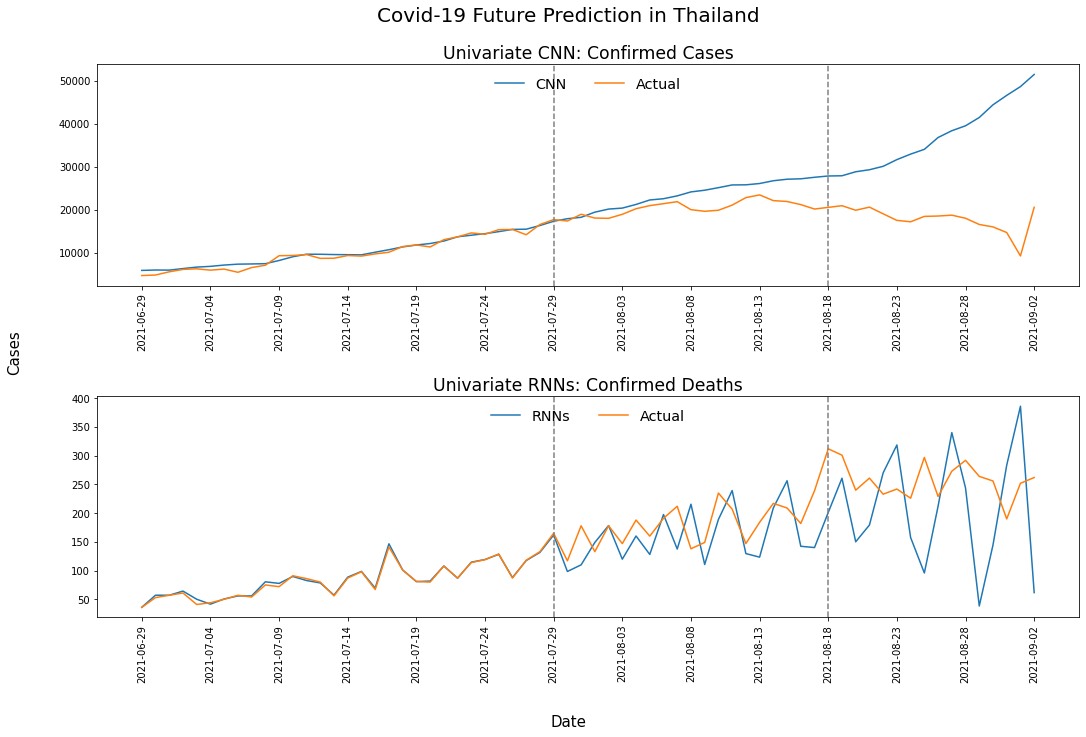

In [131]:
tick_spacing = 5

fig, axes = plt.subplots(2, 1, figsize=(15,10)) 
fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

# Univariate confirmed cases
axes[0].plot(pred['Date'], pred['uni_i'], label = "CNN")
axes[0].plot(pred['Date'], act['Cases_daily'], label = "Actual")
axes[0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0].set_title("Univariate CNN: Confirmed Cases", fontsize = 'xx-large')
axes[0].tick_params('x',labelrotation=90)
axes[0].axvline(dt.datetime(2021, 7, 29), color="gray", linestyle="--")
axes[0].axvline(dt.datetime(2021, 8, 18), color="gray", linestyle="--")
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# Univariate confirmed deaths
axes[1].plot(pred['Date'],pred['uni_d'], label = "RNNs")
axes[1].plot(pred['Date'], act['Deaths_daily'], label = "Actual")
axes[1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1].set_title("Univariate RNNs: Confirmed Deaths", fontsize = 'xx-large')
axes[1].tick_params('x',labelrotation=90)
axes[1].axvline(dt.datetime(2021, 7, 29), color="gray", linestyle="--")
axes[1].axvline(dt.datetime(2021, 8, 18), color="gray", linestyle="--")
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()

### Multivariate confirmed cases (CNN)

In [133]:
# CNN

cnn_i_p_pred0 = future_prediction_multi(data_i, model_cnn_i_p, days_predicted, y_cnn_i_p_total0)

# convert the prediction back to original values
cnn_i_p_pred = cnn_i_p_pred0*stdev(data.Cases_daily) + mean(data.Cases_daily)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Multivariate confirmed deaths (RNNs)

In [134]:
# RNN

rnn_d_p_pred0 = future_prediction_multi(data_d, model_rnn_d_p, days_predicted, y_rnn_d_p_total0)

# convert the prediction back to original values
rnn_d_p_pred = rnn_d_p_pred0*stdev(data.Deaths_daily) + mean(data.Deaths_daily)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plot -- Multivariate

In [135]:
pred_multi = pd.concat([Date.reset_index(drop = True), 
                  cnn_i_p_pred, 
                  rnn_d_p_pred],
                 axis=1)
pred_multi.columns = ['Date', 'multi_i', 'multi_d']


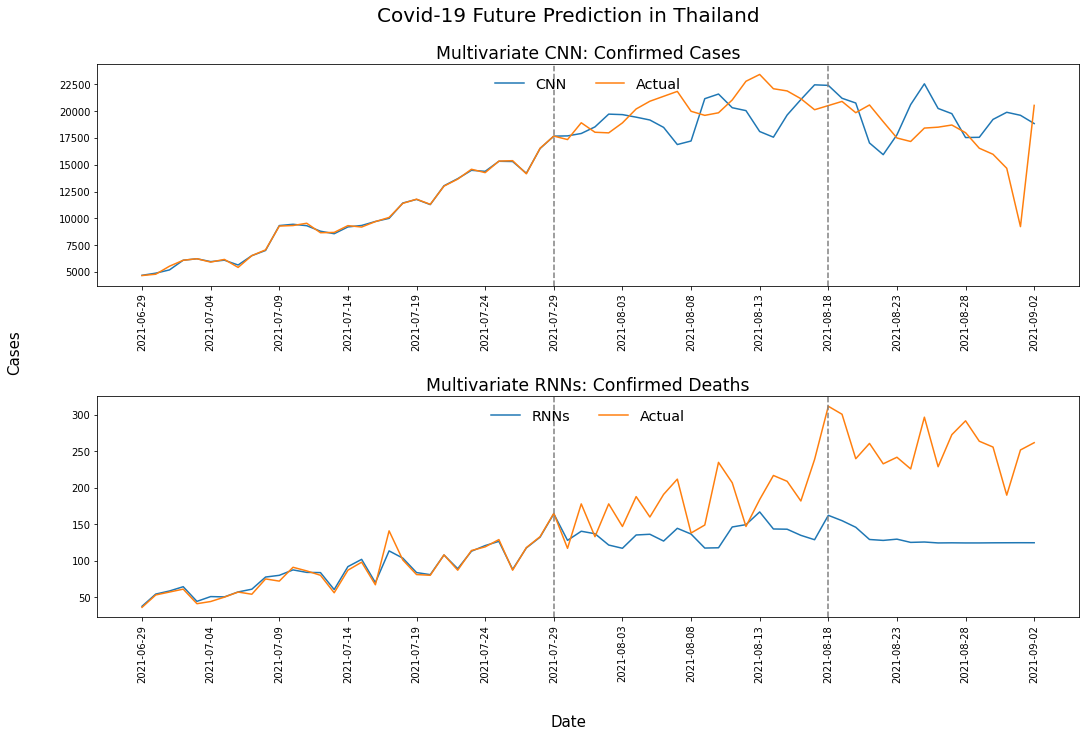

In [136]:
tick_spacing = 5

fig, axes = plt.subplots(2, 1, figsize=(15,10)) 
fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

# Univariate confirmed cases
axes[0].plot(pred_multi['Date'], pred_multi['multi_i'], label = "CNN")
axes[0].plot(pred_multi['Date'], act['Cases_daily'], label = "Actual")
axes[0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0].set_title("Multivariate CNN: Confirmed Cases", fontsize = 'xx-large')
axes[0].tick_params('x',labelrotation=90)
axes[0].axvline(dt.datetime(2021, 7, 29), color="gray", linestyle="--")
axes[0].axvline(dt.datetime(2021, 8, 18), color="gray", linestyle="--")
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# Univariate confirmed deaths
axes[1].plot(pred_multi['Date'],pred_multi['multi_d'], label = "RNNs")
axes[1].plot(pred_multi['Date'], act['Deaths_daily'], label = "Actual")
axes[1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1].set_title("Multivariate RNNs: Confirmed Deaths", fontsize = 'xx-large')
axes[1].tick_params('x',labelrotation=90)
axes[1].axvline(dt.datetime(2021, 7, 29), color="gray", linestyle="--")
axes[1].axvline(dt.datetime(2021, 8, 18), color="gray", linestyle="--")
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()